# Create Maps of Temperature for a Given Day by NERC Region


In [1]:
# Start by importing the packages we need:
import os
import datetime

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


## Set the Directory Structure


In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
hw_cs_data_dir =  '/Users/burl878/Documents/Code/code_repos/gdo_climate_toolsuite_visualizations/data/'
nerc_shapefile_dir =  '/Users/burl878/Documents/Code/code_repos/gdo_climate_toolsuite_visualizations/data/nerc_shapefiles/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/gdo_climate_toolsuite_visualizations/plots/'


## Extract the Temperature Data for a Given Day


In [3]:
# Define a extract the temperature variables for a given day:
def process_temperature_data(hw_cs_data_dir: str, day: str):
    
    # Read in the raw time series data for all NERC regions:
    df = pd.read_csv((hw_cs_data_dir + 'nerc_temperature_time_series.csv'))

    # Rename the NERC region variable to match what's in the shapefile:
    df.rename(columns={'NERC': 'NERC_Region'}, inplace=True)

    # Convert from Kelvin to Fahrenheit and round off the values:
    df['T_min'] = (((df['T_min'] - 273.15)*1.8)+32).round(2)
    df['T_mean'] = (((df['T_mean'] - 273.15)*1.8)+32).round(2)
    df['T_max'] = (((df['T_max'] - 273.15)*1.8)+32).round(2)

    # Set 'date' to a datetime variable subset to just the date you want to plot:
    df['Date'] = pd.to_datetime(df['date'])
    
    # Subset to just the data for NERC region you want to use:
    subset_df = df[(df['Date'] == pd.to_datetime(day))].copy()
    subset_df = subset_df.sort_values(['NERC_Region'])

    # Rename the columns because I'm OCD:
    subset_df.rename(columns={'T_min': 'T_Min','T_mean': 'T_Mean','T_max': 'T_Max'}, inplace=True)

    # Only keep the columns we need:
    output_df = subset_df[['NERC_Region','Date','T_Min','T_Mean','T_Max']].copy()
    
    return output_df


In [4]:
# Test the function:
output_df = process_temperature_data(hw_cs_data_dir = hw_cs_data_dir, 
                                     day = '2021-06-21')

output_df


,NERC_Region,Date,T_Min,T_Mean,T_Max
242354,1,2021-06-21,73.16,87.70,102.95
242356,2,2021-06-21,61.70,72.88,85.34
242355,3,2021-06-21,77.27,84.50,93.66
242366,4,2021-06-21,76.26,81.96,88.32
242365,5,2021-06-21,64.12,72.65,82.06
242353,6,2021-06-21,59.64,71.53,83.96
242362,7,2021-06-21,51.74,63.76,81.86
242359,8,2021-06-21,65.30,74.74,91.22
242361,9,2021-06-21,74.81,80.49,87.27
242360,10,2021-06-21,73.53,78.43,86.32


## Make the Plot


In [9]:
def plot_nerc_temperature_map(day: str, cmin: int, cmax: int, hw_cs_data_dir: str, image_output_dir: str, image_resolution: int, save_images=False):

    # Read in NERC region name file and extract the name:
    nerc = pd.read_csv((hw_cs_data_dir + 'nerc_region_names.csv'))
    nerc.rename(columns={'number': 'NERC_Region'}, inplace=True)

    # Read in the NERC region shapefile and rename the ID variable:
    regions_df = gpd.read_file(os.path.join(nerc_shapefile_dir, 'NERC_Regions_Subregions.shp')).rename(columns={'ID': 'NERC_Region'})
    regions_df['NERC_Region'] = regions_df['NERC_Region'].astype(int)

    # Reproject the shapefile onto latitute and longitude coordinates:
    regions_df  = regions_df.to_crs({'init': 'EPSG:4269'})

    # Add in a central coordinate for the labels:
    regions_df['coords'] = regions_df['geometry'].apply(lambda x: x.representative_point().coords[:])
    regions_df['coords'] = [coords[0] for coords in regions_df['coords']]
    
    # Process the data using the function defined above:
    temp_df = process_temperature_data(hw_cs_data_dir = hw_cs_data_dir, 
                                       day = day)

    # Merge the temperature data and NERC shapefile together using county NERC region codes to join them:
    mapping_df = regions_df.merge(temp_df, on='NERC_Region', how='left')
    mapping_df = mapping_df.merge(nerc, on='NERC_Region', how='left')

    # Set the colormap:
    cmap = plt.get_cmap('RdBu_r', 24)
    
    # Make the plot:
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    plt.rcParams['font.size'] = 18
    ax1 = mapping_df.plot(column='T_Min', ax=ax, edgecolor='gray', linewidth=0.5, cmap=cmap, vmin=cmin, vmax=cmax, legend=True, legend_kwds={'label': 'Population-Weighted Minimum Temperature [$^\circ$F]', 'orientation': 'vertical'})
    mapping_df.apply(lambda x: ax.annotate(text=x['short_name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=11), axis=1);
    regions_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.25, zorder=2)
    ax.set_xlim(-126.5, -66);
    ax.set_xlabel('Longitude', fontsize=18); 
    ax.set_ylim(24, 50); 
    ax.set_ylabel('Latitude', fontsize=18);
    ax.set_title(('Daily Minimum Temperature by NERC Region: ' + day), fontsize=21)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + 'T_Min_Map_' + day + '.png'), dpi=image_resolution, bbox_inches='tight')
       #plt.close()

    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    plt.rcParams['font.size'] = 18
    ax1 = mapping_df.plot(column='T_Max', ax=ax, edgecolor='gray', linewidth=0.5, cmap=cmap, vmin=cmin, vmax=cmax, legend=True, legend_kwds={'label': 'Population-Weighted Maximum Temperature [$^\circ$F]', 'orientation': 'vertical'})
    mapping_df.apply(lambda x: ax.annotate(text=x['short_name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=11), axis=1);
    regions_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.25, zorder=2)
    ax.set_xlim(-126.5, -66);
    ax.set_xlabel('Longitude', fontsize=18); 
    ax.set_ylim(24, 50); 
    ax.set_ylabel('Latitude', fontsize=18);
    ax.set_title(('Daily Maximum Temperature by NERC Region: ' + day), fontsize=21)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + 'T_Max_Map_' + day + '.png'), dpi=image_resolution, bbox_inches='tight')
       #plt.close()
        

/Users/burl878/.pyenv/versions/tell/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


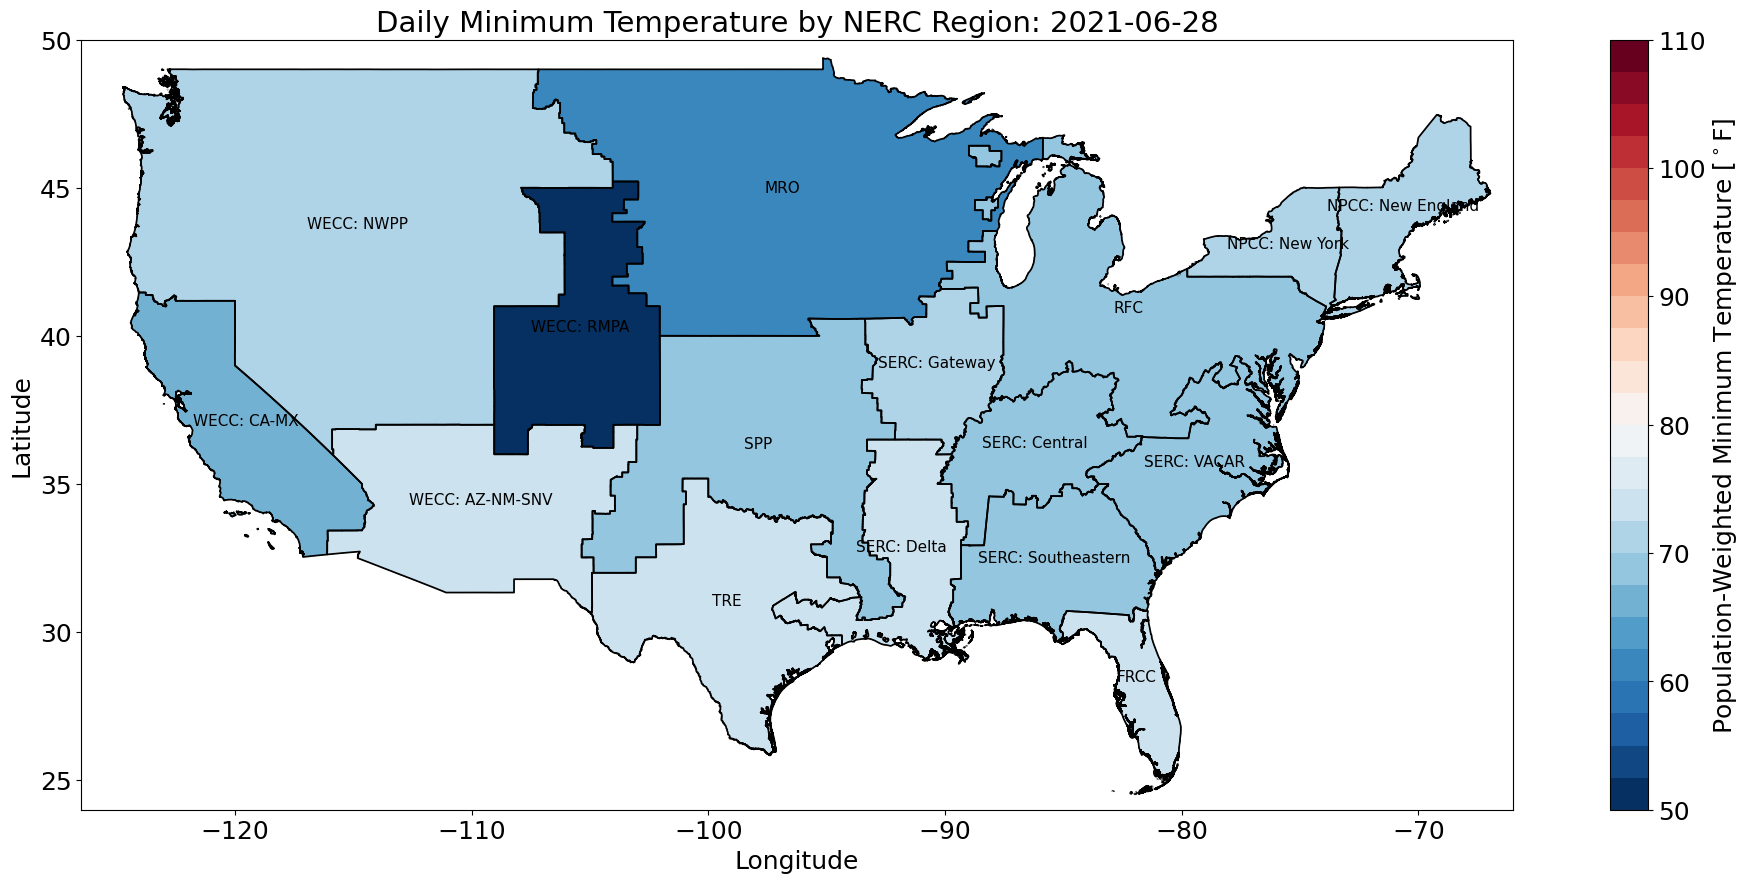

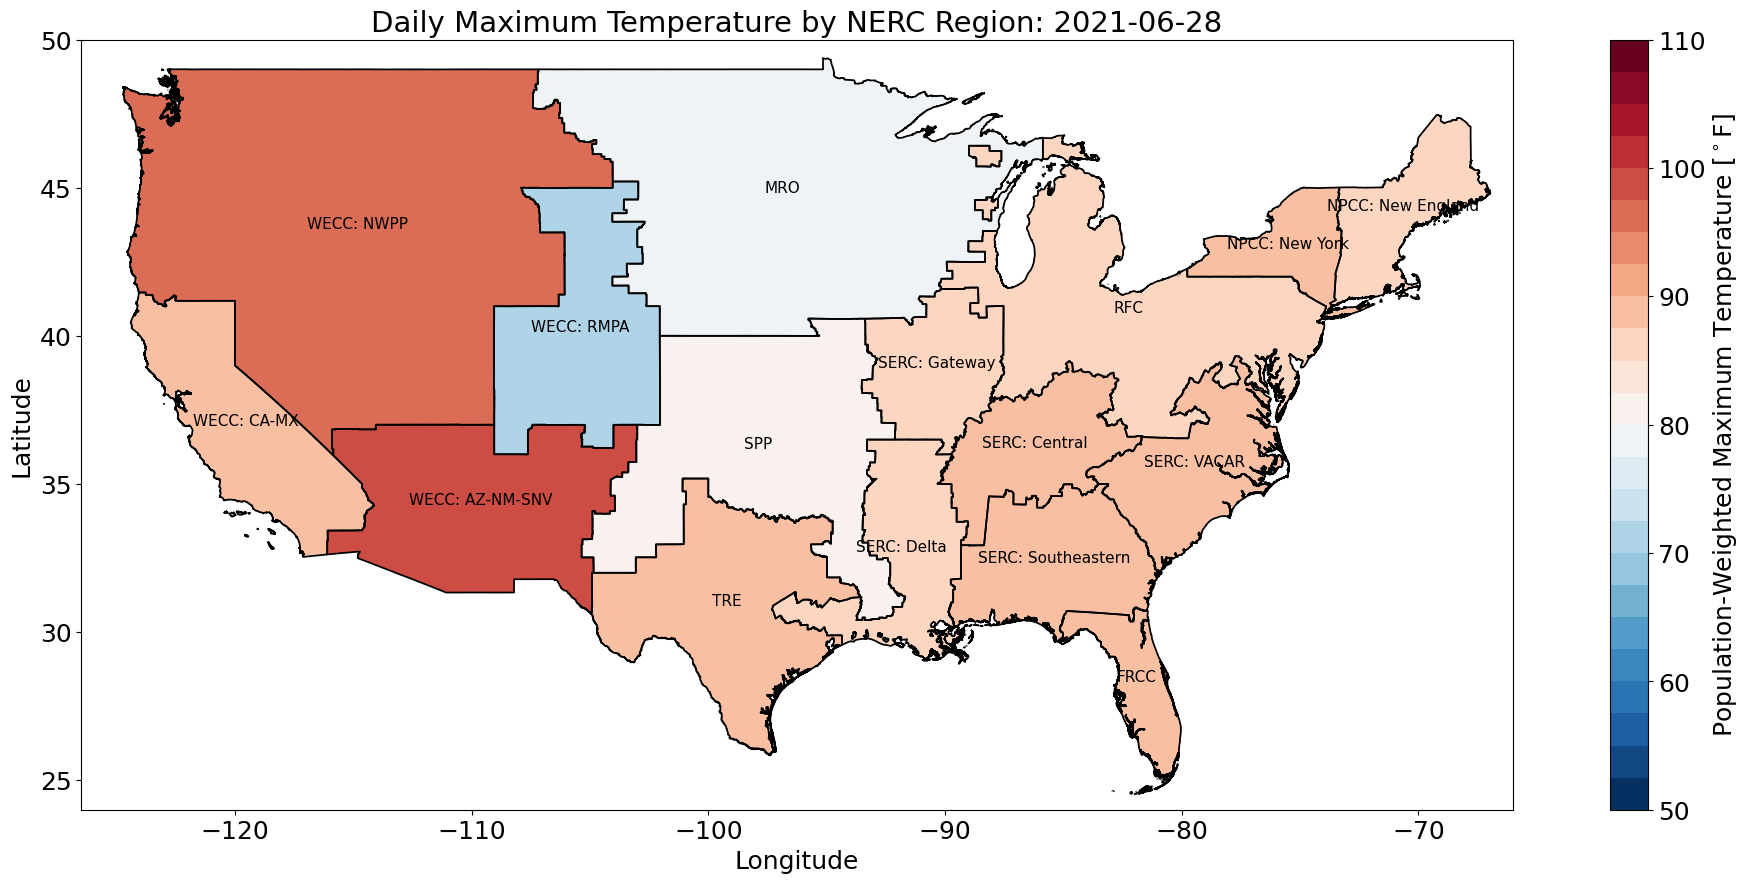

In [10]:
# Make the plot
plot_nerc_temperature_map(day = '2021-06-28',
                          cmin = 50,
                          cmax = 110,
                          hw_cs_data_dir = hw_cs_data_dir, 
                          image_output_dir = image_output_dir, 
                          image_resolution = 150, 
                          save_images = True)
